In [1]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.feature as cfeature
import os
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import random

/Users/rachelstumpf/ulmo/ulmo/utils/image_utils.py:8: UserWarning: healpy not installed.  Not all functions will work!
  warnings.warn("healpy not installed.  Not all functions will work!")


In [2]:
table_2012 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2012.parquet')

In [3]:
l3s = table_2012.iloc[:,0:22]

In [27]:
l3s['row'] = ((90 - l3s['VIIRS_lat']) * (9000 / 180)).astype(int) - 32
l3s['col'] = ((l3s['VIIRS_lon'] + 180) * (18000 / 360)).astype(int) - 32
l3s['lat'] = l3s['VIIRS_lat']
l3s['lon'] = l3s['VIIRS_lon']

l3s['viirs_gmt_date'] = l3s['VIIRS_datetime'].dt.date
l3s_start_time = datetime.time(1, 30, 0)
l3s['combined_datetime'] = pandas.to_datetime(l3s['viirs_gmt_date'].astype(str) + ' ' + str(l3s_start_time))
l3s['l3s_local'] = (l3s['combined_datetime'] + pandas.to_timedelta(l3s['VIIRS_lon'] * 4, unit='minutes')).dt.round('S')

l3s['l3s_local'] = pandas.to_datetime(l3s['l3s_local'].astype(str))
l3s['l3s_local_minus1'] = pandas.to_datetime((l3s['l3s_local'] - datetime.timedelta(days=1)).astype(str))
l3s['l3s_local_plus1'] = pandas.to_datetime((l3s['l3s_local']+ datetime.timedelta(days=1)).astype(str))

l3s.loc[:,'local_timedelta'] = pandas.to_timedelta(l3s.loc[:,'VIIRS_lon'] / 15, unit='H')
l3s.loc[:,'local_suntime'] = l3s.loc[:,'VIIRS_datetime'] + l3s.loc[:,'local_timedelta']
normalized_date = l3s.loc[:,'local_suntime'].dt.normalize()
time_component_timedelta = pandas.to_timedelta(l3s.loc[:,'local_suntime'].dt.hour, unit='h') + pandas.to_timedelta(l3s['local_suntime'].dt.minute, unit='m') + pandas.to_timedelta(l3s.loc[:,'local_suntime'].dt.second, unit='s')
l3s.loc[:,'L2_local_suntime'] = normalized_date + time_component_timedelta

time_diff_minus1 = abs(l3s['L2_local_suntime'] - l3s['l3s_local_minus1'])
time_diff = abs(l3s['L2_local_suntime'] - l3s['l3s_local'])
time_diff_plus1 = abs(l3s['L2_local_suntime'] - l3s['l3s_local_plus1'])

closest_index = np.argmin([time_diff_minus1, time_diff, time_diff_plus1], axis=0)

l3s['closest_date'] = l3s.apply(lambda row: row['l3s_local_minus1'] if closest_index[row.name] == 0
                                 else (row['l3s_local'] if closest_index[row.name] == 1
                                 else row['l3s_local_plus1']), axis=1)

l3s['datetime'] = l3s['closest_date'] - pandas.to_timedelta(l3s['VIIRS_lon'] * 4, unit='minutes').dt.round('S')
l3s['date'] = pandas.to_datetime(l3s['datetime'].dt.date)

l3s['ex_filename'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    l3s['date'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')
#l3s = l3s.drop(['viirs_gmt_date', 'combined_datetime', 'l3s_local', 'l3s_local_minus1', 'l3s_local_plus1', 'local_timedelta', 'local_suntime', 'date', 'min_time_diff', 'closest_date'], axis=1)

In [28]:
chosen_one = l3s.iloc[100876:100877]

In [6]:
def show_image(img: np.ndarray, cm=None, cbar: bool = True, flipud=True,
               vmnx=(-1, 1), show=False, set_aspect=None, clbl=None,
               ax=None, title=None, caption=None):
    """Display the cutout image
    Args:
        img (np.ndarray): cutout image
        cm ([type], optional): Color map to use. Defaults to None.
            If None, load the heatmap above
        cbar (bool, optional): If True, show a color bar. Defaults to True.
        flipud (bool, optional): If True, flip the image up/down. Defaults to True.
        vmnx (tuple, optional): Set vmin, vmax. Defaults to (-1, 1).
        set_aspect (str, optional):
            Passed to ax.set_aspect() if provided
        ax (matplotlib.Axis, optional): axis to use for the plot
        title (str, optional): title for the plot
        caption (str, optional): caption for the plot
    Returns:
        matplotlib.Axis: axis containing the plot
    """
    if cm is None:
        _, cm = plotting.load_palette()

    ax = sns.heatmap(np.flipud(img), xticklabels=[],
                     vmin=vmnx[0], vmax=vmnx[1], ax=ax,
                     yticklabels=[], cmap=cm, cbar=cbar,
                     cbar_kws={'label': clbl})

    if title is not None:
        ax.set_title(title)

    if caption is not None:
        ax.text(0.5, 1.08, caption, horizontalalignment='center',
                fontsize=10, transform=ax.transAxes)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    return ax

In [17]:
# check time!

# plot cutout at VIIRS_datetime, l3s_local_plus1, l3s_local, and l3s_local_minus1, plotting the datetime as caption
# let's take row 293939
pp_file = "s3://viirs/PreProc/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5"
pp_idx = 60899

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
viirs = image_utils.grab_image(matching_row, local_file = "/Users/rachelstumpf/Desktop/VIIRS/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5")
#L3S_far_ex = np.flipud(np.fliplr(L3S_row0))[0,...]
viirs = viirs[0,...]

In [30]:
chosen_one.loc[:,'minus1'] = chosen_one.loc[:,'l3s_local_minus1'] - pandas.to_timedelta(chosen_one.loc[:,'VIIRS_lon'] * 4, unit='minutes').dt.round('S')
chosen_one.loc[:,'minus1date'] = pandas.to_datetime(chosen_one.loc[:,'minus1'].dt.date)

chosen_one.loc[:,'ex_filename_minus1'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    chosen_one.loc[:,'minus1date'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

chosen_one.loc[:,'same_date'] = chosen_one.loc[:,'l3s_local'] - pandas.to_timedelta(chosen_one.loc[:,'VIIRS_lon'] * 4, unit='minutes').dt.round('S')
chosen_one.loc[:,'same_date'] = pandas.to_datetime(chosen_one.loc[:,'same_date'].dt.date)

chosen_one.loc[:,'ex_filename_date'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    chosen_one.loc[:,'same_date'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

chosen_one.loc[:,'plus1'] = chosen_one.loc[:,'l3s_local_plus1'] - pandas.to_timedelta(chosen_one.loc[:,'VIIRS_lon'] * 4, unit='minutes').dt.round('S')
chosen_one.loc[:,'plus1date'] = pandas.to_datetime(chosen_one.loc[:,'plus1'].dt.date)

chosen_one.loc[:,'ex_filename_plus1'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    chosen_one.loc[:,'plus1date'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_12667/988053893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_one.loc[:,'minus1'] = chosen_one.loc[:,'l3s_local_minus1'] - pandas.to_timedelta(chosen_one.loc[:,'VIIRS_lon'] * 4, unit='minutes').dt.round('S')
/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_12667/988053893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_one.loc[:,'minus1date'] = pandas.to_datetime(chosen_one.loc[:,'minus1'].dt.date)
/var/folders/_r/z

In [31]:
chosen_one

,VIIRS_row,VIIRS_col,VIIRS_UID,VIIRS_LL,VIIRS_pp_file,VIIRS_pp_idx,VIIRS_T90,VIIRS_T10,VIIRS_DT,VIIRS_pp_type,...,date,ex_filename,minus1,minus1date,ex_filename_minus1,same_date,ex_filename_date,plus1,plus1date,ex_filename_plus1
100876,1008,2880,133712274135867935,-48.352417,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5,60899,15.290009,13.98999,1.300018,0,...,2012-05-20,/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/141/20120520120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc,2012-05-18 01:30:00,2012-05-18,/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/139/20120518120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc,2012-05-19,/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/140/20120519120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc,2012-05-20 01:30:00,2012-05-20,/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/141/20120520120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc


In [19]:
minus1_filename = chosen_one['ex_filename_minus1'].values
date_filename = chosen_one['ex_filename_date'].values
plus1_filename = chosen_one['ex_filename_plus1'].values

In [32]:
minus1 = xarray.open_dataset('/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/139/20120518120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc', engine = 'h5netcdf')
date = xarray.open_dataset('/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/140/20120519120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc', engine='h5netcdf')
plus1 = xarray.open_dataset('/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/141/20120520120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc', engine='h5netcdf')

In [33]:
minus1 = minus1.squeeze('time')['sea_surface_temperature']
date = date.squeeze('time')['sea_surface_temperature']
plus1 = plus1.squeeze('time')['sea_surface_temperature']

lat = chosen_one['lat'].iloc[0]
lon = chosen_one['lon'].iloc[0]

window_size_degrees = 64 * 0.02

minus1 = (minus1.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))).values
minus1 = minus1 - np.nanmean(minus1)

date = (date.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))).values
date = date - np.nanmean(date)

plus1 = (plus1.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))).values
plus1 = plus1 - np.nanmean(plus1)

In [34]:
minus1_title = chosen_one['l3s_local_minus1'].values
date_title = chosen_one['l3s_local'].values
plus1_title = chosen_one['l3s_local_plus1'].values
viirs_title = chosen_one['L2_local_suntime'].values

In [15]:
pandas.set_option('display.max_colwidth', None)
chosen_one

,VIIRS_row,VIIRS_col,VIIRS_UID,VIIRS_LL,VIIRS_pp_file,VIIRS_pp_idx,VIIRS_T90,VIIRS_T10,VIIRS_DT,VIIRS_pp_type,...,closest_date,datetime,date,ex_filename,minus1,minus1date,ex_filename_minus1,plus1,plus1date,ex_filename_plus1
100876,1008,2880,133712274135867935,-48.352417,s3://viirs/PreProc/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5,60899,15.290009,13.98999,1.300018,0,...,2012-05-19 17:24:43,2012-05-20 01:30:00,2012-05-20,/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/141/20120520120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc,2012-05-18 01:30:00,2012-05-18,/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/139/20120518120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc,2012-05-20 01:30:00,2012-05-20,/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/141/20120520120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc


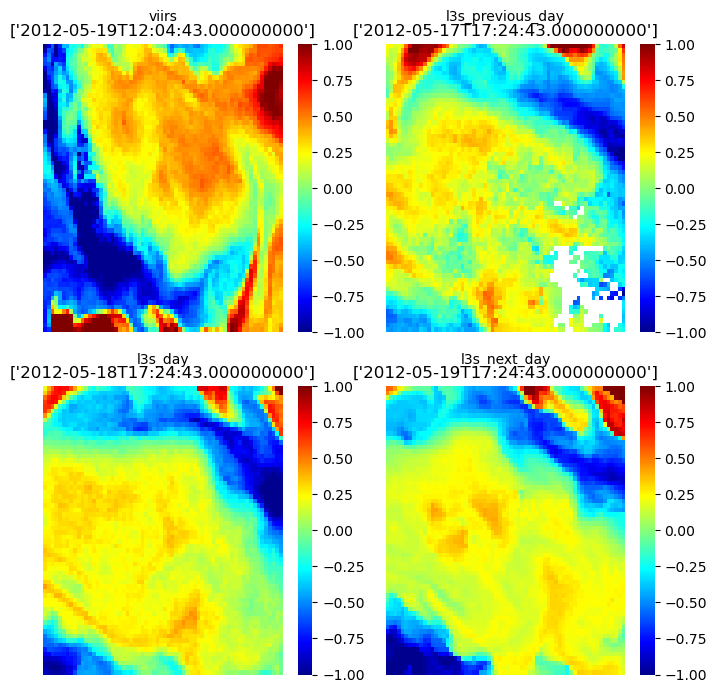

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

all_images = [viirs, minus1, date, plus1]
all_titles = [viirs_title, minus1_title, date_title, plus1_title]
all_captions = ['viirs', 'l3s_previous_day', 'l3s_day', 'l3s_next_day']

vmnx = (-1, 1)

for img, title, caption, ax in zip(all_images, all_titles, all_captions, axes.flatten()):
    show_image(img, ax=ax, title=title, vmnx=vmnx, caption=caption)

plt.tight_layout()
plt.show()

In [37]:
l3s2 = table_2012.iloc[:,0:22]

In [104]:
from datetime import datetime, timedelta

In [38]:
# convert l3s to GMT time instead

l3s2['row'] = ((90 - l3s2['VIIRS_lat']) * (9000 / 180)).astype(int) - 32
l3s2['col'] = ((l3s2['VIIRS_lon'] + 180) * (18000 / 360)).astype(int) - 32
l3s2['lat'] = l3s2['VIIRS_lat']
l3s2['lon'] = l3s2['VIIRS_lon']

l3s2['L3S_GMT_datetime'] = l3s2['VIIRS_datetime'].dt.normalize() + pandas.to_timedelta('01:30:00')
l3s2['L3S_GMT_datetime_minus1'] = l3s2['L3S_GMT_datetime'] - pandas.DateOffset(days=1)
l3s2['L3S_GMT_datetime_plus1'] = l3s2['L3S_GMT_datetime'] + pandas.DateOffset(days=1)

time_diff_minus1 = abs(l3s2['VIIRS_datetime'] - l3s2['L3S_GMT_datetime_minus1'])
time_diff = abs(l3s2['VIIRS_datetime'] - l3s2['L3S_GMT_datetime'])
time_diff_plus1 = abs(l3s2['VIIRS_datetime'] - l3s2['L3S_GMT_datetime_plus1'])

closest_index = np.argmin([time_diff_minus1, time_diff, time_diff_plus1], axis=0)
l3s2['closest_L3S_GMT_datetime'] = np.where(closest_index == 0, l3s2['L3S_GMT_datetime_minus1'],
                                           np.where(closest_index == 1, l3s2['L3S_GMT_datetime'],
                                                    l3s2['L3S_GMT_datetime_plus1']))

l3s2['datetime'] = l3s2['closest_L3S_GMT_datetime']
l3s2['date'] = pandas.to_datetime(l3s2['datetime'].dt.date)

l3s2['ex_filename'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    l3s['date'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

In [39]:
chosen_one = l3s2.iloc[293941:293942]
chosen_one.loc[:,'minus1date'] = pandas.to_datetime(chosen_one.loc[:,'L3S_GMT_datetime_minus1'].dt.date)

chosen_one.loc[:,'ex_filename_minus1'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    chosen_one.loc[:,'minus1date'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

chosen_one.loc[:,'samedate'] = pandas.to_datetime(chosen_one.loc[:,'L3S_GMT_datetime'].dt.date)

chosen_one.loc[:,'ex_filename_samedate'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    chosen_one.loc[:,'samedate'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

chosen_one.loc[:,'plus1date'] = pandas.to_datetime(chosen_one.loc[:,'L3S_GMT_datetime_plus1'].dt.date)

chosen_one.loc[:,'ex_filename_plus1'] = (
    '/Volumes/Aqua-1/Hackathon/daily/l3s_fields/' +
    chosen_one.loc[:,'plus1date'].dt.strftime('%Y/%j/%Y%m%d') +
    '120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

minus1_filename = chosen_one.loc[:,'ex_filename_minus1'].values
date_filename = chosen_one.loc[:,'ex_filename_samedate'].values
plus1_filename = chosen_one.loc[:,'ex_filename_plus1'].values

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_12667/2198614384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_one.loc[:,'minus1date'] = pandas.to_datetime(chosen_one.loc[:,'L3S_GMT_datetime_minus1'].dt.date)
/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_12667/2198614384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_one.loc[:,'ex_filename_minus1'] = (
/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_12667/2198614384.py:9: SettingWithCopyWarning: 
A

In [43]:
pp_file = "s3://viirs/PreProc/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5"
pp_idx = 780092

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
viirs = image_utils.grab_image(matching_row, local_file = "/Users/rachelstumpf/Desktop/VIIRS/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5")
#L3S_far_ex = np.flipud(np.fliplr(L3S_row0))[0,...]
viirs = viirs[0,...]

In [44]:
minus1 = xarray.open_dataset('/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/365/20121230120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc', engine = 'h5netcdf')
date = xarray.open_dataset('/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2012/366/20121231120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc', engine='h5netcdf')
plus1 = xarray.open_dataset('/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2013/001/20130101120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc', engine='h5netcdf')
minus1 = minus1.squeeze('time')['sea_surface_temperature']
date = date.squeeze('time')['sea_surface_temperature']
plus1 = plus1.squeeze('time')['sea_surface_temperature']

lat = chosen_one['lat'].iloc[0]
lon = chosen_one['lon'].iloc[0]

window_size_degrees = 64 * 0.02

minus1 = (minus1.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))).values
minus1 = minus1 - np.nanmean(minus1)

date = (date.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))).values
date = date - np.nanmean(date)

plus1 = (plus1.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))).values
plus1 = plus1 - np.nanmean(plus1)

minus1_title = chosen_one['L3S_GMT_datetime_minus1'].values
date_title = chosen_one['L3S_GMT_datetime'].values
plus1_title = chosen_one['L3S_GMT_datetime_plus1'].values
viirs_title = chosen_one['VIIRS_datetime'].values

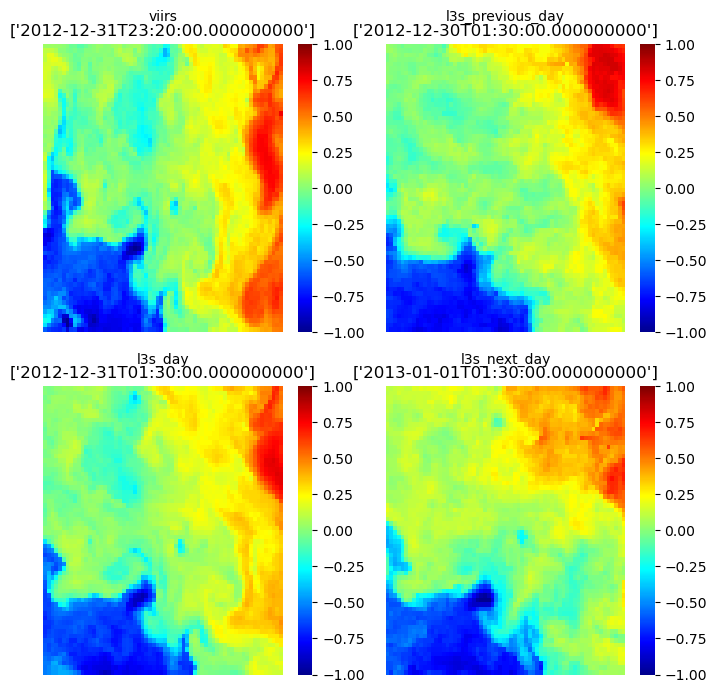

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

all_images = [viirs, minus1, date, plus1]
all_titles = [viirs_title, minus1_title, date_title, plus1_title]
all_captions = ['viirs', 'l3s_previous_day', 'l3s_day', 'l3s_next_day']

vmnx = (-1, 1)

for img, title, caption, ax in zip(all_images, all_titles, all_captions, axes.flatten()):
    show_image(img, ax=ax, title=title, vmnx=vmnx, caption=caption)

plt.tight_layout()
plt.show()